# 계절성을 갖는 ARIMA


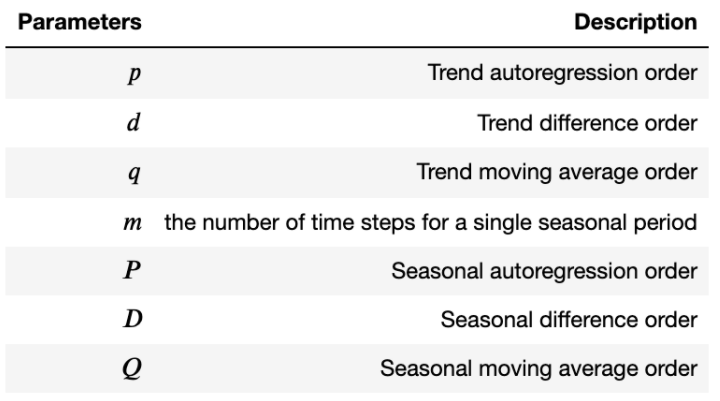

In [3]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 432x288 with 0 Axes>

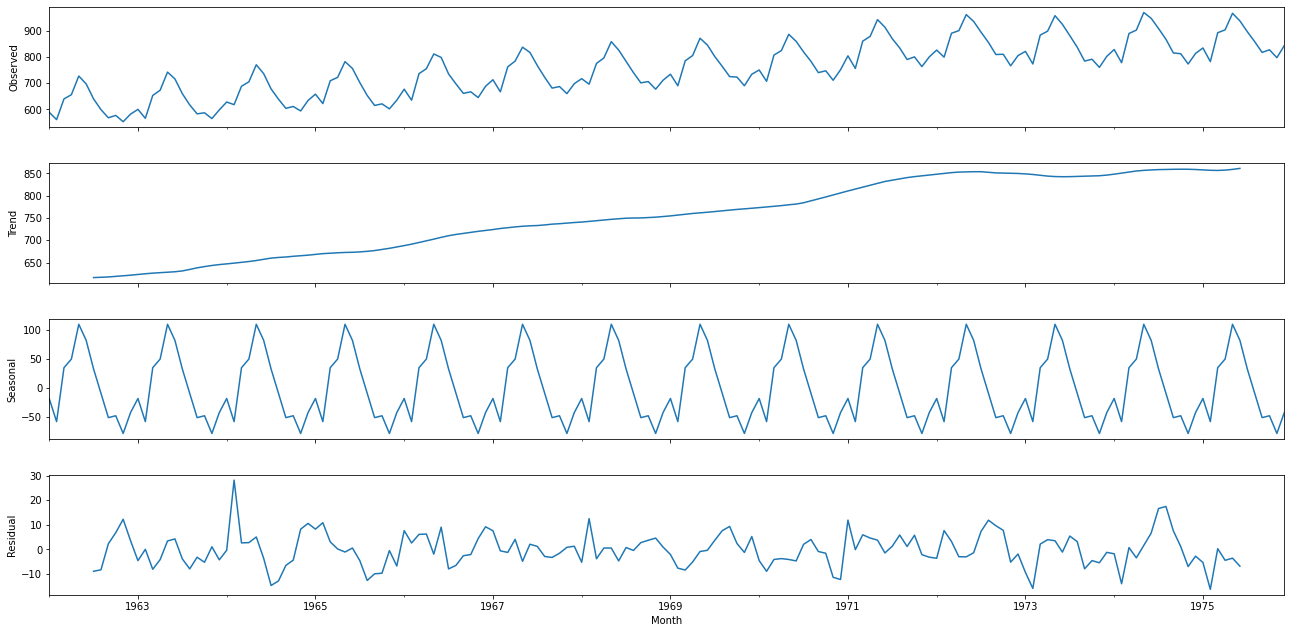

In [13]:
# csv 경로
path = '/content/drive/MyDrive/Colab Notebooks/AI_허현준/11주차 머신러닝/datasets/monthly-milk-production.csv'

# csv read
df = pd.read_csv(path)

# "Month" 컬럼 Datetime으로 형변환
df['Month'] = pd.to_datetime(df['Month'])

# index 설정
df = df.set_index("Month")

# 계절성 분석
decomposition = seasonal_decompose(df["pounds per cow"])

# 시각화
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(20 , 10)

p-value: 0.6330986048291793


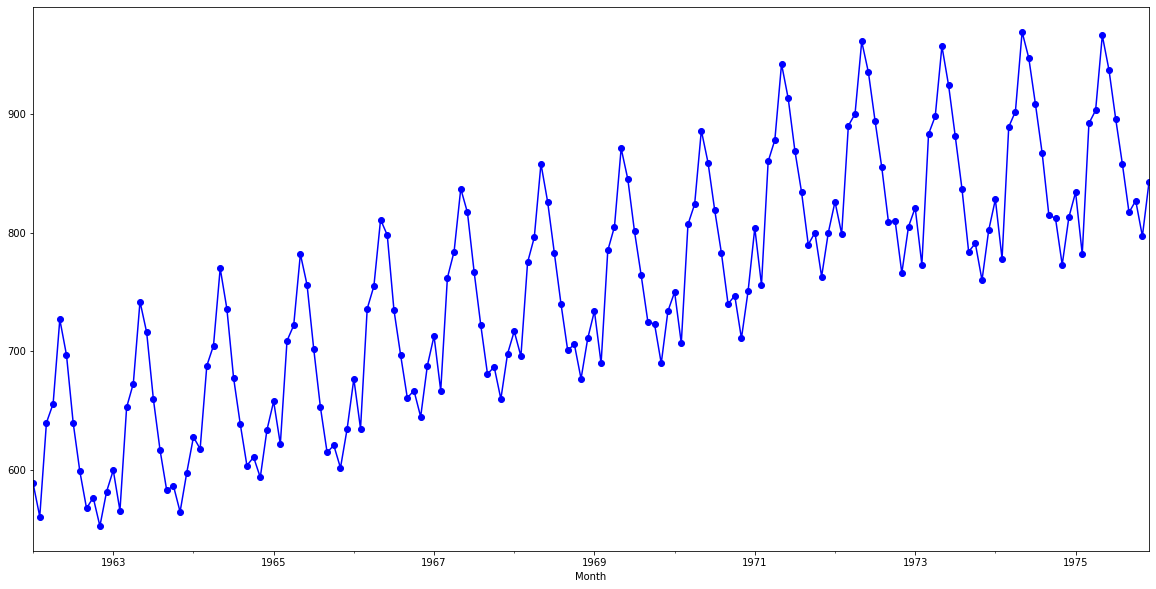

In [14]:
# 안정적인지 확인
result = adfuller(df.loc[:"1974-12-31", 'pounds per cow'])
print("p-value:",result[1]) # 0.5 보다 커서 안정적이지 않음 
print("=" * 100)

# 안정적이지 않은 놈
plt.figure(figsize = (20, 10))
df["pounds per cow"].plot(color = 'b', marker = 'o')

0.030068004001784086


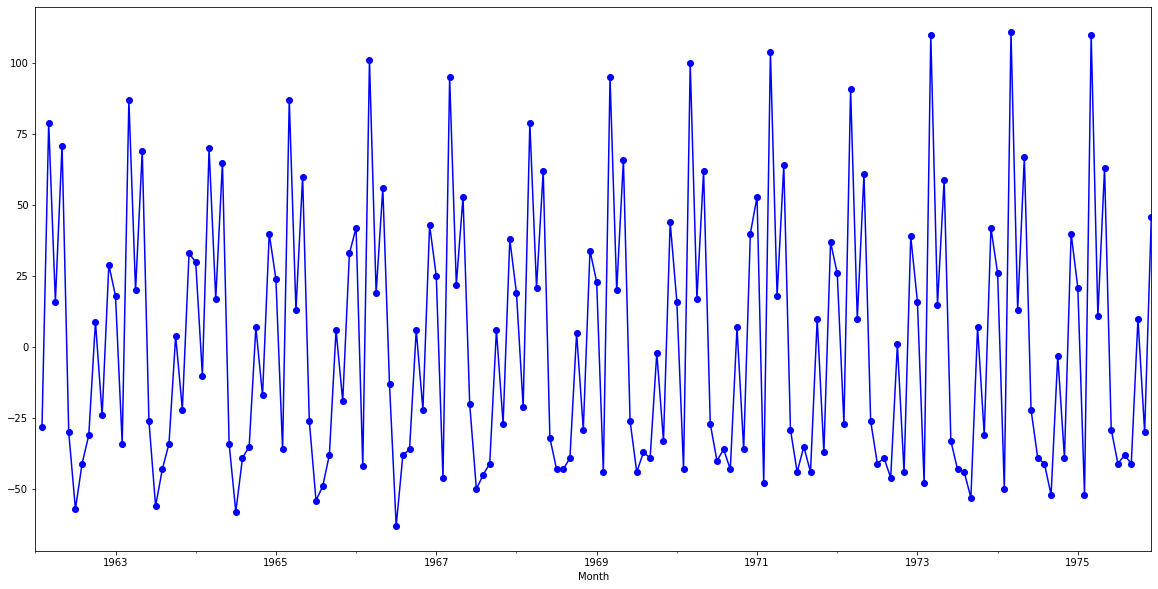

In [15]:
# 계절성이 있지만 안정적이지 않은 데이터(Non Stationary)를 안정적인 데이터로 변환(Stationary)

# 안정적이지 않다 : 평균의 차이가 심하다
# 앞의 데이터와의 차이를 이용함 (증가치)

df['1st diff'] = df['pounds per cow'] - df['pounds per cow'].shift(1)

# null 행 삭제 후 안정적인지 분석
result = adfuller(df['1st diff'].dropna())

# p-value
print(result[1])

# 시각화
plt.figure(figsize = (20, 10))
df['1st diff'].plot(color ='b', marker = 'o')

1.1126989332083225e-26


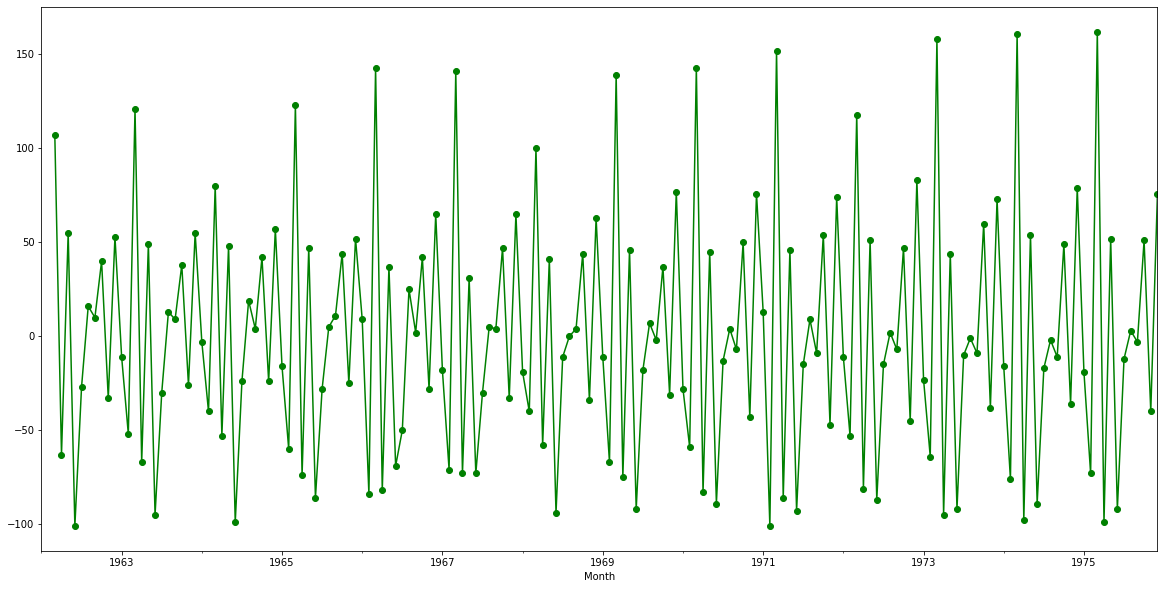

In [9]:
# 2차분
df['2nd diff'] = df['1st diff'] - df['1st diff'].shift(1)

result = adfuller(df['2nd diff'].dropna())

print(result[1])

# 시각화
plt.figure(figsize = (20, 10))
df["2nd diff"].plot(color ='g',marker ='o')

In [10]:
# 데이터가 1년주기로 반복되는것으로 보여짐
# 따라서 1년 차이 계산
# 계절성 없는 ARIMA : 전, 전전데이터사용
# 계절성 있는 ARIMA : 전, 전전 + 12개월 전 데이터 사용
#  seasonal_order(P, D, Q, s)
# p = 1 or 2 : 12개월전, 24개월전   

df['last year']=df['pounds per cow'].shift(12)
df.loc["1966-01-01":"1966-12-01",:][["pounds per cow", "last year"]]

,pounds per cow,last year
Month,,
1966-01-01,677,658.0
1966-02-01,635,622.0
1966-03-01,736,709.0
1966-04-01,755,722.0
1966-05-01,811,782.0
1966-06-01,798,756.0
1966-07-01,735,702.0
1966-08-01,697,653.0
1966-09-01,661,615.0


In [16]:
model = sm.tsa.statespace.SARIMAX(df.loc[: "1974-12-01",'pounds per cow'],
                                  order = (0,1,0),
                                  seasonal_order = (0, 1, 0, 12) 
                                  )

# df.loc[: "1974-12-01",'pounds per cow'] 분석
results = model.fit()

# 결과 조회
print(results.summary())
print("=" *100)

# 'pred'  컬럼추가
df['pred'] = 0

# 예측값 12개 대입
df.loc["1975-01-01":,'pred']  = results.forecast(12)

# 조회
df[["pounds per cow","pred"]].loc["1975-01-01" :]

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -518.390
Date:                            Fri, 03 Sep 2021   AIC                           1038.780
Time:                                    07:28:06   BIC                           1041.743
Sample:                                01-01-1962   HQIC                          1039.984
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        82.4639      6.573     12.546      0.000      69.581      95.347
Ljung-Box (Q):                     

,pounds per cow,pred
Month,,
1975-01-01,834,839.0
1975-02-01,782,789.0
1975-03-01,892,900.0
1975-04-01,903,913.0
1975-05-01,966,980.0
1975-06-01,937,958.0
1975-07-01,896,919.0
1975-08-01,858,878.0
1975-09-01,817,826.0


In [ ]:
# AIC 
# 최적의 파라미터 찾기

p, d, q= [range(0,2)] * 3
s = range(12, 13)

order_list = list(itertools.product(p,d,q))
sorder_list = list(itertools.product(p,d,q,s))

for od in order_list:
  
  for sod in sorder_list:
    print("od = ",od)
    print("sod = ", sod)

    try:
      mod = sm.tsa.statespace.SARIMAX(df.loc[:"1974-12-31",'pounds per cow'],
                                      order = od,
                                      seasonal_order = sod)  
      # 데이터 분석
      results = mod.fit()

      print("aic = ", results.aic)
      print("=" * 100) 

    except Exception as e:
      print(e)

In [ ]:
# 위에서 찾은 최적의 파라미터로 SARIMAX 객체 생성
mod = sm.tsa.statespace.SARIMAX(df.loc[:"1974-12-31",'pounds per cow'],
                                      order = (0, 1, 1), 
                                      seasonal_order = (0, 1, 1, 12))
                                      # results = order * seasonal_order 
results = model.fit()

df['pred'] = 0
df.loc["1975-01-01":, "pred"] = results.forecast(12)

df.tail(15)

In [ ]:
plt.figure(figsize = (20, 10))
df.loc[:,"pounds per cow"].plot(color = 'b', marker = 'o')

df.loc["1975-01-01":,'pred'].plot(color = 'r', marker = 'o')

In [ ]:
mean_squared_error(df.loc['1975-01-01' : , "pounds per cow"],df.loc['1975-01-01' : , "pred"])

202.5833333333318

# 실습
- 300~338


In [52]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
%matplotlib inline

<Figure size 432x288 with 0 Axes>

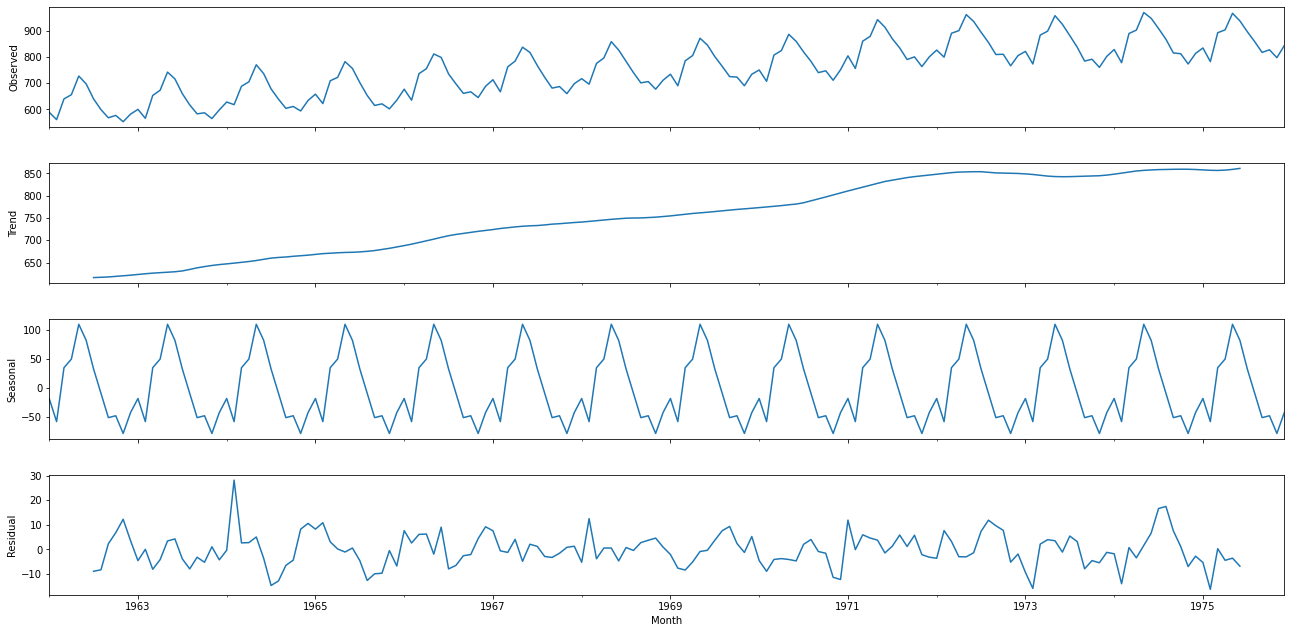

In [53]:
# csv 경로
path = '/content/drive/MyDrive/Colab Notebooks/AI_허현준/11주차 머신러닝/datasets/monthly-milk-production.csv'

# csv read
df = pd.read_csv(path)

# "Month" 컬럼 Datetime으로 형변환
df['Month'] = pd.to_datetime(df['Month'])

# index 설정
df = df.set_index("Month")

# 계절성 분석
decomposition = seasonal_decompose(df["pounds per cow"])

# 계절성 확인 시각화
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(20 , 10)

In [54]:
result = adfuller(df.loc[:"1974-12-31", 'pounds per cow'])
result[1] # 0.5 보다 커서 안정적이지 않음 

# 계절성은 갖지만 안정적이지 않은 데이터(Non Stationary)를 안정적인 데이터로 변환(Stationary)
# 앞의 데이터와의 차이를 이용함 (증가치)

# 1차분
df['1st diff'] = df['pounds per cow'] - df['pounds per cow'].shift(1)
result1 = adfuller(df['1st diff'].dropna()) # null 행삭제후  p-value 확인 ->  안정적인지 분석
print("1차분 p-value : ",result1[1]) # p-value

# 2차분
df['2nd diff'] = df['1st diff'] - df['1st diff'].shift(1)
result2 = adfuller(df['2nd diff'].dropna())
print("2차분 p-value : ",result2[1])

# 데이터가 1년주기로 반복되는것으로 보여짐
# 따라서 1년 차이 계산
df['seasonal 1st diff'] = df['1st diff'] - df["1st diff"].shift(12)
result12 = adfuller(df['seasonal 1st diff'].dropna())
print("12개월 p-value : ",result12[1])

1차분 p-value :  0.030068004001782136
2차분 p-value :  1.112698933207948e-26
12개월 p-value :  1.865423431878848e-05


Text(0.5, 1.0, 'seasonal  p-value : 1.865423431878848e-05')

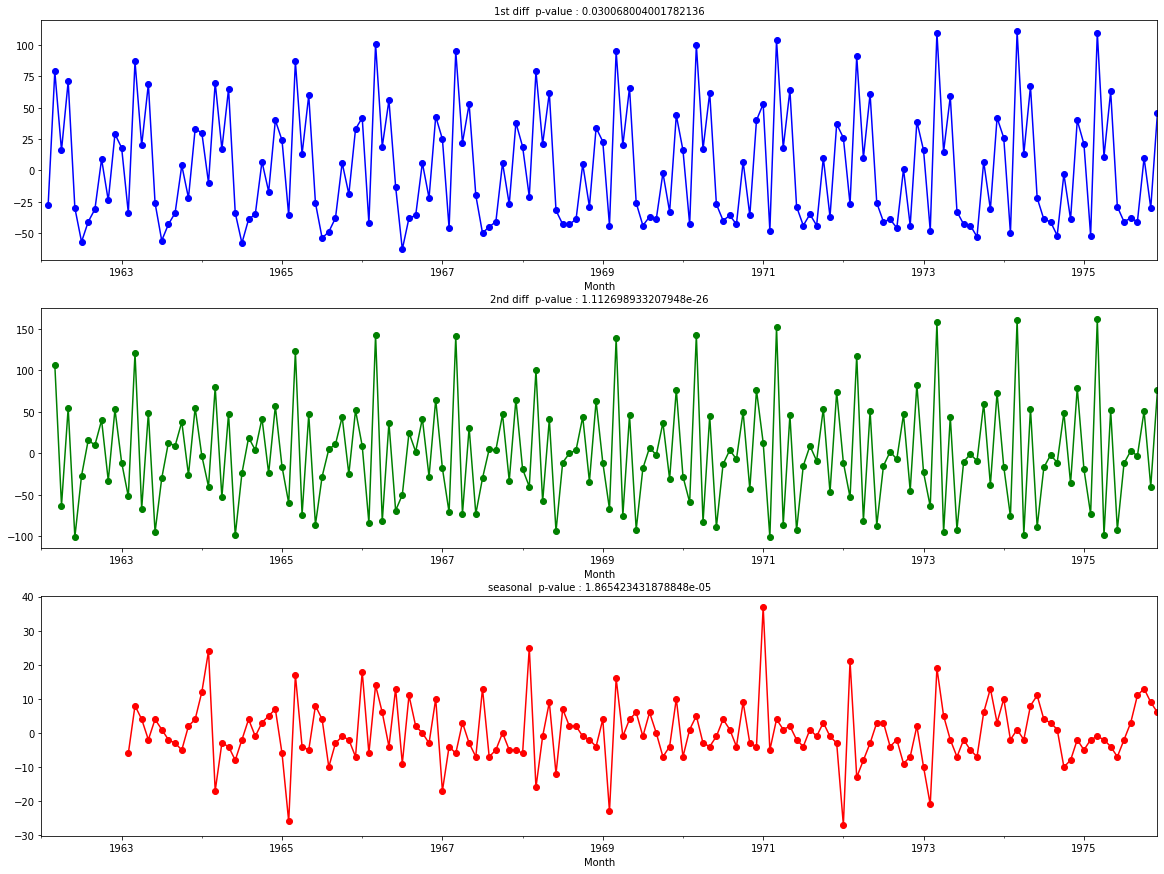

In [55]:
# 시각화
plt.figure(figsize = (20, 15))

# 1차분 시각화
plt.subplot(3, 1, 1) 
df['1st diff'].plot(color = 'b', marker = 'o')
plt.title('1st diff  p-value : {}'.format(result1[1]),fontsize=10)

# 2차분 시각화
plt.subplot(3, 1, 2) 
df["2nd diff"].plot(color = 'g', marker = 'o')
plt.title('2nd diff  p-value : {}'.format(result2[1]),fontsize=10)

# 12개월 차 시각화
plt.subplot(3, 1, 3) 
df['seasonal 1st diff'].plot(color = 'r', marker = 'o')
plt.title('seasonal  p-value : {}'.format(result12[1]),fontsize=10)

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -518.390
Date:                            Fri, 03 Sep 2021   AIC                           1038.780
Time:                                    13:18:17   BIC                           1041.743
Sample:                                01-01-1962   HQIC                          1039.984
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        82.4639      6.573     12.546      0.000      69.581      95.347
Ljung-Box (Q):                     

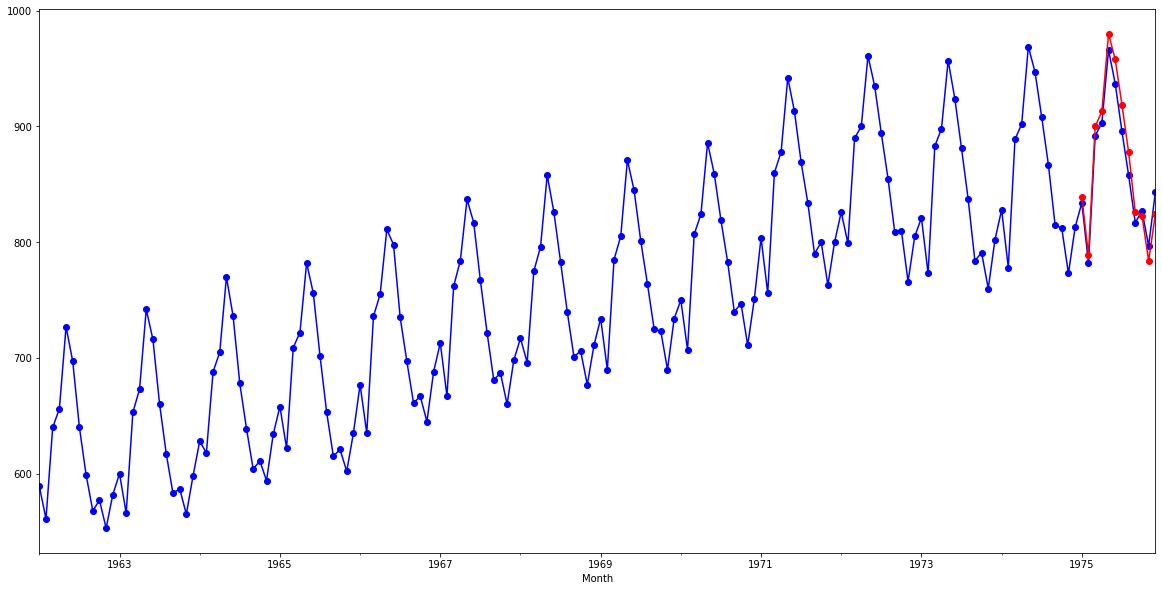

In [56]:
# 임의의 파라미터로 생성한 SARIMAX객체 
model = sm.tsa.statespace.SARIMAX(df.loc[: "1974-12-31",'pounds per cow'],
                                  order = (0,1,0),
                                  seasonal_order = (0, 1, 0, 12)
                                  )

# df.loc[: "1974-12-31",'pounds per cow'] 분석
results = model.fit()

# 결과 조회
print(results.summary())

df['pred'] = 0
df.loc["1975-01-01":,'pred']  = results.forecast(12)

# 임의의 파라미터로 생성한 SARIMAX로 예측한값 시각화
plt.figure(figsize = (20, 10))
df.loc[:,"pounds per cow"].plot(color = 'b', marker = 'o')
df.loc['1975-01-01' : , "pred"].plot(color = 'r', marker = 'o')

In [57]:
# AIC 
# 최적의 파라미터 찾기
p, d, q= [range(0,2)]*3
s = range(12, 13)

order_list = list(itertools.product(p,d,q))
sorder_list = list(itertools.product(p,d,q,s))

aic_params = []


for order in order_list:
  for sorder in sorder_list:
    try:
      mod = sm.tsa.statespace.SARIMAX(df.loc[:"1974-12-31",'pounds per cow'],
                                      order = order,
                                      seasonal_order = sorder)
      # 데이터 분석
      results = mod.fit()

      print('order : {} sorder : {} - AIC : {}'.format(order, sorder, results.aic))

      aic_params.append((results.aic, order, sorder))
    
    except Exception as e:
      print(e)



order : (0, 0, 0) sorder : (0, 0, 0, 12) - AIC : 2511.4449112677116
order : (0, 0, 0) sorder : (0, 0, 1, 12) - AIC : 2340.782909151395
order : (0, 0, 0) sorder : (0, 1, 0, 12) - AIC : 1349.3200342937753
order : (0, 0, 0) sorder : (0, 1, 1, 12) - AIC : 1314.0923931521534
order : (0, 0, 0) sorder : (1, 0, 0, 12) - AIC : 1544.1895349340364
order : (0, 0, 0) sorder : (1, 0, 1, 12) - AIC : 1509.1228961371044
order : (0, 0, 0) sorder : (1, 1, 0, 12) - AIC : 1301.4399545507545
order : (0, 0, 0) sorder : (1, 1, 1, 12) - AIC : 1265.5074187759878
order : (0, 0, 1) sorder : (0, 0, 0, 12) - AIC : 2315.17576859551
order : (0, 0, 1) sorder : (0, 0, 1, 12) - AIC : 2143.970803930067
order : (0, 0, 1) sorder : (0, 1, 0, 12) - AIC : 1221.8070218257026
order : (0, 0, 1) sorder : (0, 1, 1, 12) - AIC : 1212.2702886708205
order : (0, 0, 1) sorder : (1, 0, 0, 12) - AIC : 1402.3106982702443
order : (0, 0, 1) sorder : (1, 0, 1, 12) - AIC : 1393.7537525276275
order : (0, 0, 1) sorder : (1, 1, 0, 12) - AIC : 120

In [58]:
# AIC가 가장 낮은 파라미터로 객체 생성
mod = sm.tsa.statespace.SARIMAX(df.loc[:"1974-12-31",'pounds per cow'],
                                      order = (min(aic_params)[1]),
                                      seasonal_order = (min(aic_params)[2]))

results = mod.fit()
print(results.summary())

df['pred'] = 0
df.loc["1975-01-01":, "pred"] = results.forecast(12)

df.tail(15)

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -491.084
Date:                            Fri, 03 Sep 2021   AIC                            988.167
Time:                                    13:19:26   BIC                            997.056
Sample:                                01-01-1962   HQIC                           991.779
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2579      0.080     -3.226      0.001      -0.415      -0.101
ma.S.L12      -0.6116      0.078   

,pounds per cow,1st diff,2nd diff,seasonal 1st diff,pred
Month,,,,,
1974-10-01,812,-3.0,49.0,-10.0,0.000000
1974-11-01,773,-39.0,-36.0,-8.0,0.000000
1974-12-01,813,40.0,79.0,-2.0,0.000000
1975-01-01,834,21.0,-19.0,-5.0,838.762196
1975-02-01,782,-52.0,-73.0,-2.0,794.301602
1975-03-01,892,110.0,162.0,-1.0,899.129487
1975-04-01,903,11.0,-99.0,-2.0,913.417297
1975-05-01,966,63.0,52.0,-4.0,976.683534
1975-06-01,937,-29.0,-92.0,-7.0,950.274526


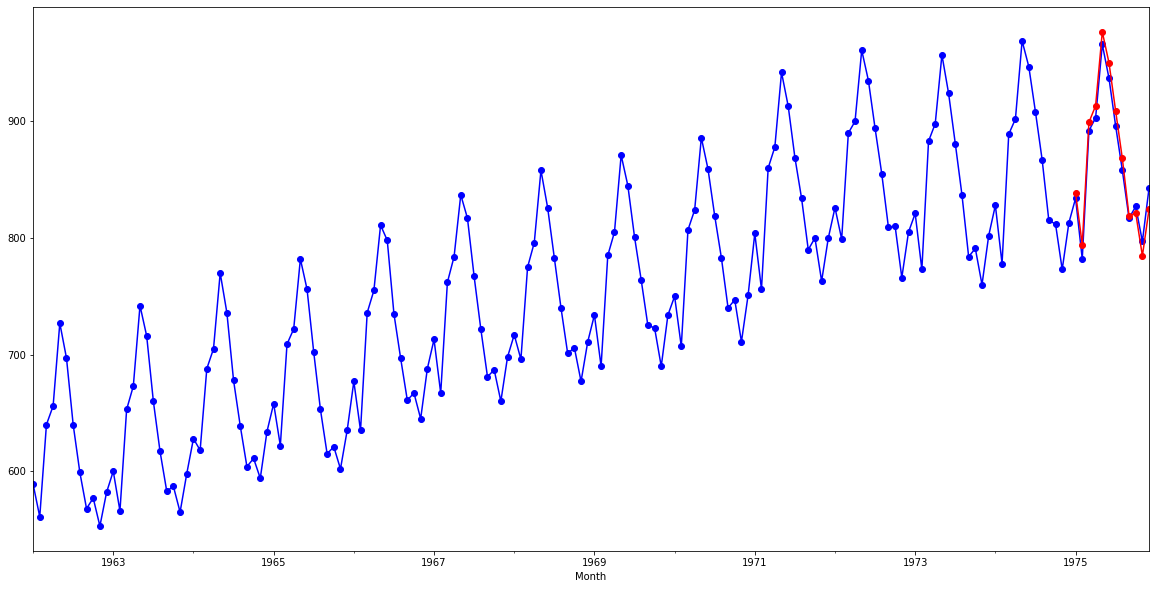

In [59]:
plt.figure(figsize = (20, 10))
df.loc[:,"pounds per cow"].plot(color = 'b', marker = 'o')

df.loc["1975-01-01":,'pred'].plot(color = 'r', marker = 'o')

In [60]:
mean_squared_error(df.loc['1975-01-01' : , "pounds per cow"],df.loc['1975-01-01' : , "pred"])

117.61589819758863

In [ ]:
df

,pounds per cow,shift,1st diff
Month,,,
1962-01-01,589.0,NaN,NaN
1962-02-01,561.0,589.0,-28.0
1962-03-01,640.0,561.0,79.0
1962-04-01,656.0,640.0,16.0
1962-05-01,727.0,656.0,71.0
...,...,...,...
1975-08-01,858.0,896.0,-38.0
1975-09-01,817.0,858.0,-41.0
1975-10-01,827.0,817.0,10.0
